В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import roc_auc_score

from process_bank_churn_upd import preprocess_data, preprocess_new_data

from mlxtend.plotting import plot_decision_regions

from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [36]:
raw_df = pd.read_csv('bank-customer-churn-prediction-dlu/train.csv', index_col=0)
cols_to_delete = ['Surname']
target_col = 'Exited'
X_train, train_targets, X_val, val_targets, input_cols, scaler, encoder = preprocess_data(raw_df, target_col, cols_to_delete, scale_numeric=True)

In [37]:
X_train.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,,
7180,0.988516,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.984351,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.997112,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.997533,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.987805,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [38]:
knn = KNeighborsClassifier()

knn.fit(X_train, train_targets)

KNeighborsClassifier()

In [39]:
# Predict probabilities
y_train_probs = knn.predict_proba(X_train)[:, 1]
y_val_probs = knn.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation datasets
train_auroc = roc_auc_score(train_targets, y_train_probs)
val_auroc = roc_auc_score(val_targets, y_val_probs)

print(f"Train AUROC: {train_auroc}")
print(f"Validation AUROC: {val_auroc}")

Train AUROC: 0.955875881017124
Validation AUROC: 0.8524864531174978


Висновок: Різниця по метриці якості AUROC на навчальному і на валідаційному датасетах в 10%, що не мало і вказує на перенавчання модельки, а також на навчальних даних не вийшло досягти максимальної якості модельки, це може означати, що ми обрали або занадто легкий алгоритм, або треба гратись з параметрами моделі і налаштовувати кількість сусідів.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [40]:
params_knn = {'n_neighbors': np.arange(1, 40)}
knn_gs = GridSearchCV(knn, params_knn, cv=5)
knn_gs.fit(X_train, train_targets)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39])})

In [41]:
knn_best = knn_gs.best_estimator_

print(knn_gs.best_params_, knn_gs.best_score_)

{'n_neighbors': 9} 0.8670833333333334


In [42]:
knn_gs.best_estimator_

KNeighborsClassifier(n_neighbors=9)

In [43]:
knn_best = knn_gs.best_estimator_

In [44]:
# Predict probabilities
y_train_probs_best = knn_best.predict_proba(X_train)[:, 1]
y_val_probs_best = knn_best.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation datasets
train_best_auroc = roc_auc_score(train_targets, y_train_probs_best)
val_best_auroc = roc_auc_score(val_targets, y_val_probs_best)

print(f"Train AUROC: {train_best_auroc}")
print(f"Validation AUROC: {val_best_auroc}")

Train AUROC: 0.9407387399383632
Validation AUROC: 0.8807174703340421


Висновок: метрики моделі тепер вже не відрізняються на 10% між навчальним і валідаційним датасетами. Тобто у нас вже не таке перенавчання на тренувальних даних. Якщо порівнювати з алгоритмом дерев то у мене тут інший підхід в обробці даних (взяла той що у Анни) і тепер якість досягається вища, але думаю, що насправді під цю задачу краще підійде дерево, бо у анни там був вищий показник десь 91% на валідаційному датасеті, в той час як тут у мене 88%.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_seed`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [47]:
dt = DecisionTreeClassifier(random_state=42)

params_dt = {
    'max_depth': np.arange(1, 20, 2),
    'max_leaf_nodes': np.arange(2, 10),
}

dt_gs = GridSearchCV(estimator=dt, param_grid=params_dt, cv=3, scoring='roc_auc')

In [48]:
dt_gs.fit(X_train, train_targets)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'max_leaf_nodes': array([2, 3, 4, 5, 6, 7, 8, 9])},
             scoring='roc_auc')

In [49]:
dt_best = dt_gs.best_estimator_

print(dt_gs.best_params_, dt_gs.best_score_)

{'max_depth': 5, 'max_leaf_nodes': 9} 0.8990230600400091


In [50]:
# Predict probabilities
y_train_probs_dt_best = dt_best.predict_proba(X_train)[:, 1]
y_val_probs_dt_best = dt_best.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation datasets
train_dt_best_auroc = roc_auc_score(train_targets, y_train_probs_dt_best)
val_dt_best_auroc = roc_auc_score(val_targets, y_val_probs_dt_best)

print(f"Train AUROC: {train_dt_best_auroc}")
print(f"Validation AUROC: {val_dt_best_auroc}")

Train AUROC: 0.9001138615074584
Validation AUROC: 0.898395980519926


Висновок: Ця модель однозначно краще, бо я поміняла підхід до генерації фічей, і тепер у мене більш вищі метрики по якості. Попередньо було 81%.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [52]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [55]:
dt_random_search = RandomizedSearchCV(estimator=dt,
                                     param_distributions=params_dt,
                                     n_iter = 40,
                                     cv=5,
                                     scoring='roc_auc',
                                     random_state=42)

In [56]:
dt_random_search.fit(X_train, train_targets)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'max_leaf_nodes': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19]),
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 5, 10, 20],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='roc_auc')

In [57]:
dt_random_search_best = dt_random_search.best_estimator_

print(dt_random_search.best_params_, dt_random_search.best_score_)

{'splitter': 'best', 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_leaf_nodes': 14, 'max_features': None, 'max_depth': 16, 'criterion': 'entropy'} 0.9105253694321098


In [58]:
# Predict probabilities
y_train_probs_dt_random_search_best = dt_random_search_best.predict_proba(X_train)[:, 1]
y_val_probs_dt_random_search_best = dt_random_search_best.predict_proba(X_val)[:, 1]

# Calculate AUROC for training and validation datasets
train_dt_random_search_best_auroc = roc_auc_score(train_targets, y_train_probs_dt_random_search_best)
val_dt_random_search_best_auroc = roc_auc_score(val_targets, y_val_probs_dt_random_search_best)

print(f"Train AUROC: {train_dt_random_search_best_auroc}")
print(f"Validation AUROC: {val_dt_random_search_best_auroc}")

Train AUROC: 0.9169275635848141
Validation AUROC: 0.9166204815145071


5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [59]:
test_df = pd.read_csv('bank-customer-churn-prediction-dlu/test.csv', index_col=0)

In [60]:
test_df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72


In [62]:
preprocessed_test_df = preprocess_new_data(test_df.copy(), input_cols, scaler, encoder, scale_numeric=True)

In [63]:
preprocessed_test_df

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
id,,,,,,,,,,,,,,
15000,0.984482,0.365155,0.214286,0.2,0.696265,0.000000,1.0,1.0,0.789477,0.0,1.0,0.0,0.0,1.0
15001,0.987856,0.286396,0.375000,0.5,0.000000,0.333333,1.0,1.0,0.337131,1.0,0.0,0.0,0.0,1.0
15002,0.993017,0.656325,0.446429,0.8,0.000000,0.333333,1.0,0.0,0.783859,1.0,0.0,0.0,0.0,1.0
15003,0.997849,0.682578,0.482143,0.3,0.000000,0.000000,1.0,1.0,0.834571,0.0,0.0,1.0,0.0,1.0
15004,0.989270,0.384248,0.446429,0.8,0.000000,0.333333,1.0,1.0,0.718421,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.987868,0.496420,0.357143,1.0,0.000000,0.333333,1.0,1.0,0.248154,0.0,0.0,1.0,0.0,1.0
24996,0.994631,0.589499,0.375000,0.9,0.000000,0.333333,1.0,1.0,0.712578,0.0,0.0,1.0,0.0,1.0
24997,0.995859,0.818616,0.214286,0.9,0.000000,0.333333,1.0,0.0,0.024253,1.0,0.0,0.0,0.0,1.0


In [66]:
proba_predictions = dt_random_search_best.predict_proba(preprocessed_test_df)[:, 1]

In [64]:
submission = pd.read_csv('bank-customer-churn-prediction-dlu/sample_submission.csv', index_col=0)

In [67]:
submission['Exited'] = proba_predictions

In [68]:
submission['Exited'].value_counts()

0.012115    4027
0.039301     912
0.187638     789
0.770492     640
0.569848     608
0.361905     566
0.082171     543
0.059486     515
0.237911     456
0.203947     396
0.966408     349
1.000000     115
0.859649      43
0.893333      41
Name: Exited, dtype: int64

In [69]:
submission.to_csv('bank-customer-churn-prediction-dlu/submission_decision_tree_random_search_best_estimator.csv')

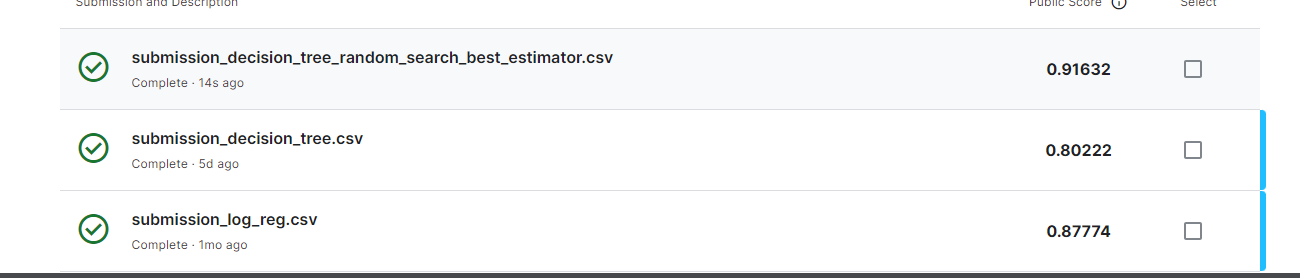